In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import iqr
from datasets import load_dataset
import seaborn as sns

In [2]:
dataset = load_dataset("humicroedit", "subtask-1")

train_df = pd.DataFrame(dataset["train"])
val_df   = pd.DataFrame(dataset["validation"])
test_df  = pd.DataFrame(dataset["test"])

Found cached dataset humicroedit (/home/gabriel/.cache/huggingface/datasets/humicroedit/subtask-1/0.0.0/209c209bc70671d8d939aefd82e51f8ff294e47504ec64ef653a93a1f13e9ed3)


  0%|          | 0/4 [00:00<?, ?it/s]

In [30]:
df = train_df

# Function to convert grades string to integer list
def grades_to_list(grades_str):
    return np.array(list(map(int, list(grades_str))))

# Apply the function to the 'grades' column
df['grades'] = df['grades'].apply(grades_to_list)

# Compute standard deviation and store in a new column
df['stddev'] = df['grades'].apply(np.std)

# Compute interquartile range and store in a new column
df['iqr'] = df['grades'].apply(iqr)

# make grades_max_5 column, which takes the 5 quantile of the grades
df['grades_max_5'] = df['grades'].apply(lambda x: np.quantile(sorted(x), [0.0, 0.25, 0.5, 0.75, 1.0], method='nearest'))

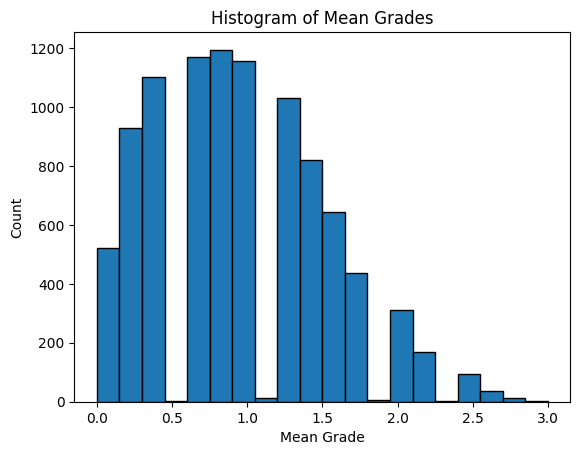

In [4]:
# 1. Histogram of mean grades
plt.hist(df['meanGrade'], bins=20, edgecolor='black')
plt.title('Histogram of Mean Grades')
plt.xlabel('Mean Grade')
plt.ylabel('Count')
plt.show()


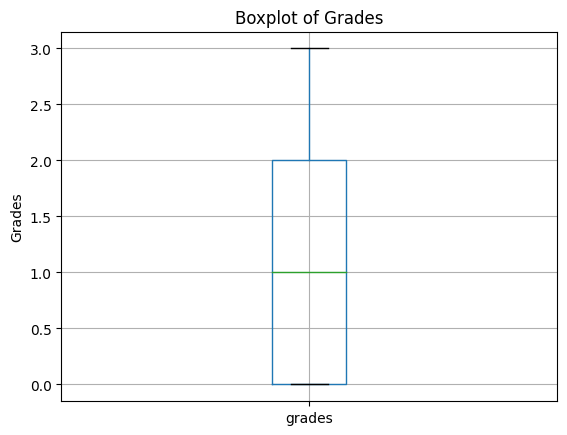

In [5]:
# Flatten the grades data
flat_data = df.explode('grades')

# Convert 'grades' to numeric
flat_data['grades'] = pd.to_numeric(flat_data['grades'])

# Boxplot of grades
flat_data.boxplot(column='grades')
plt.title('Boxplot of Grades')
plt.ylabel('Grades')
plt.show()

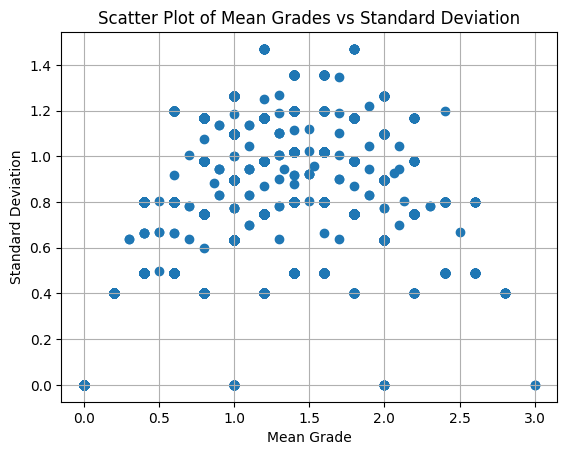

In [6]:
# 3. Scatter plot of mean grades vs standard deviation of grades
plt.scatter(df['meanGrade'], df['stddev'])
plt.title('Scatter Plot of Mean Grades vs Standard Deviation')
plt.xlabel('Mean Grade')
plt.ylabel('Standard Deviation')
plt.grid(True)
plt.show()

In [7]:
# Print 5 funniest lines
print("\n5 Funniest Lines:")
funniest = df.sort_values(by='meanGrade', ascending=False).head(5)
for i, row in funniest.iterrows():
    print(f"Original: {row['original'].replace('<Mexico/>', row['edit'])}, Mean Grade: {row['meanGrade']}")

# Print 5 least funny lines
print("\n5 Least Funny Lines:")
least_funny = df.sort_values(by='meanGrade').head(5)
for i, row in least_funny.iterrows():
    print(f"Original: {row['original'].replace('<Mexico/>', row['edit'])}, Mean Grade: {row['meanGrade']}")

# Print 5 lines with biggest variance
print("\n5 Lines With Biggest Variance:")
biggest_variance = df.sort_values(by='stddev', ascending=False).head(5)
for i, row in biggest_variance.iterrows():
    print(f"Original: {row['original'].replace('<Mexico/>', row['edit'])}, Std Dev: {row['stddev']}")



5 Funniest Lines:
Original: Recent Scandals Highlight Trump 's Chaotic <Management/> Style, Mean Grade: 3.0
Original: President Trump 's first year <anniversary/> report card , with grades from A + to F, Mean Grade: 3.0
Original: How an FBI raid fed a rumor that Orrin Hatch was about to become <president/> , Mean Grade: 2.799999952316284
Original: Trump admits tariffs could cause ' pain ' in <markets/> , Mean Grade: 2.799999952316284
Original: Kasich : Trump <tweets/> ‘ unacceptable ’, Mean Grade: 2.799999952316284

5 Least Funny Lines:
Original: Carson proposes that poor should <pay/> more rent, Mean Grade: 0.0
Original: Central Michigan University On Lockdown After <Shooting/> At Dorm Kills 2, Mean Grade: 0.0
Original:  <Devin Nunes/> tried to discredit the FBI . Instead , he proved it ’s onto something ., Mean Grade: 0.0
Original: What happened to jarred closed <testimony/> , Mean Grade: 0.0
Original: Putin 's dilemma : Scrap <term/> limits or choose a successor, Mean Grade: 0.0

5

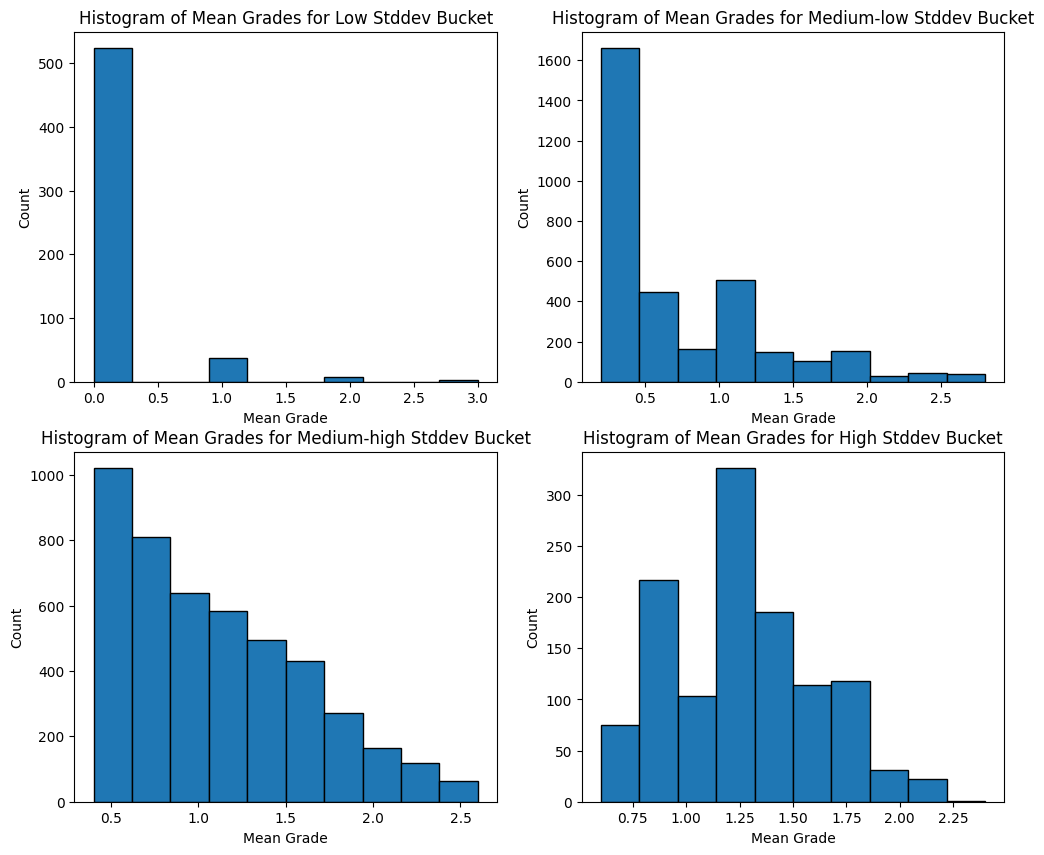

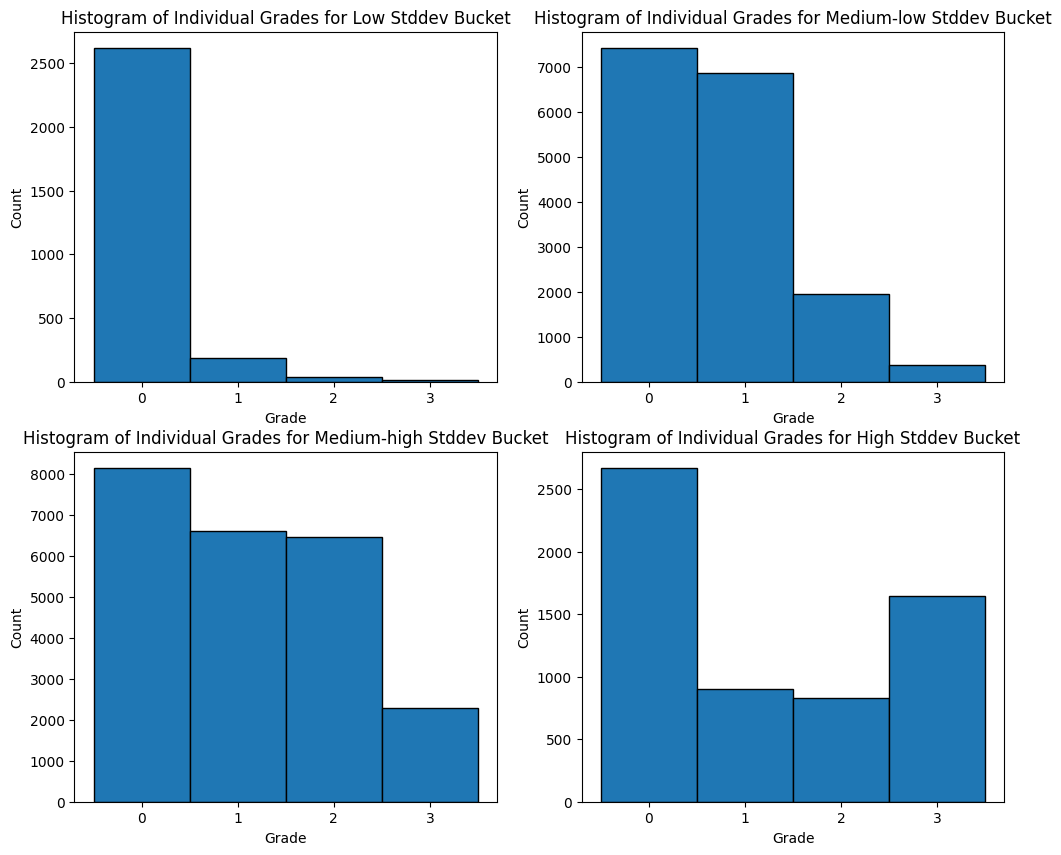

In [8]:
# 1. Bucketize stddev into 4 bins
df['stddev_bucket'] = pd.cut(df['stddev'], bins=4, labels=["low", "medium-low", "medium-high", "high"])

# Get unique labels
labels = df['stddev_bucket'].unique().sort_values()

# 2. Create a histogram of mean grades for each stddev bucket.
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
i = 0
for label in labels:
    axs[i // 2, i % 2].hist(df[df['stddev_bucket'] == label]['meanGrade'], bins=10, edgecolor='black')
    axs[i // 2, i % 2].set_title(f'Histogram of Mean Grades for {label.capitalize()} Stddev Bucket')
    axs[i // 2, i % 2].set_xlabel('Mean Grade')
    axs[i // 2, i % 2].set_ylabel('Count')
    i += 1
plt.show()

# 3. Plot a histogram of all individual grades for rows that fall into a particular stddev bucket.
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
i = 0
for label in labels:
    grades_in_bucket = df[df['stddev_bucket'] == label]['grades']
    grades_in_bucket = [item for sublist in grades_in_bucket for item in sublist]  # flatten list of lists

    axs[i // 2, i % 2].hist(grades_in_bucket, bins=range(5), edgecolor='black', align='left')
    axs[i // 2, i % 2].set_title(f'Histogram of Individual Grades for {label.capitalize()} Stddev Bucket')
    axs[i // 2, i % 2].set_xlabel('Grade')
    axs[i // 2, i % 2].set_ylabel('Count')
    axs[i // 2, i % 2].set_xticks(range(4))
    i += 1
plt.show()


In [9]:
import json

try:
    
    with open('train_topics_cache.json', 'r') as f:
        topics = json.load(f)
        df['topics'] = df['id'].apply(lambda id: topics[id])
except:

    from transformers import pipeline
    import torch
    torch.cuda.empty_cache()

    # Assume that these are your news headlines
    headlines = []
    for i, row in df.iterrows():
        o, e = row['original'], row['edit']
        #h = o.replace('<', '(').replace('/>', f', {e})')
        h = o
        headlines.append(h)

    # Define the topics you want to classify the headlines into
    topics = ["Business", "Science", "Health", "Politics", "Democrats", "Republicans", "Trump", "Biden", "Economy", "Sports", "Entertainment", "Technology", "Education", "World", "US", "Crime"]

    # Create a zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

    # Iterate over the headlines and classify each into a topic
    df['topics'] = ''

    batch_size = 1000
    i = 0
    while i < len(headlines):
        # Make the prediction
        result = classifier(headlines[i:i+batch_size], topics)

        # Get the best matching topic
        for j, r in enumerate(result):
            scores = sorted(r['scores'])
            best_topic        = r['labels'][r['scores'].index(scores[-1])]
            second_best_topic = r['labels'][r['scores'].index(scores[-2])]
            third_best_topic  = r['labels'][r['scores'].index(scores[-3])]

            #print(f'Headline: {i+j}/{len(headlines)} "{headlines[i+j]}" \nBest Matching Topics: {best_topic}, {second_best_topic}, {third_best_topic}')
            df.at[i+j, 'topics'] = [best_topic, second_best_topic, third_best_topic]

        i += batch_size
        print(f'Finished headlines {i}/{len(headlines)}')

    topics = {}
    for i, row in df.iterrows():
        topics[row['id']] = row['topics']

    with open('train_topics_cache.txt', 'w') as f:
        json.dump(topics, f)


try:
    with open('train_edit_topics_cache.json', 'r') as f:
        topics = json.load(f)
        df['edit_topics'] = df['id'].apply(lambda id: topics[id])
except:

    from transformers import pipeline
    import torch
    torch.cuda.empty_cache()

    # Assume that these are your news headlines
    headlines = []
    for i, row in df.iterrows():
        o, e = row['original'], row['edit']
        #h = o.replace('<', '(').replace('/>', f', {e})')
        #h = o
        h = e
        headlines.append(h)

    # Define the topics you want to classify the funny words
    topics = ["sexual", "bodypart", "family", "food", "trump", "politics", "children", "clothes", "fashion", "animals" , "drugs", "silly", "places", "profession", "disease", "relationships", "aging", "money" ]

    # Create a zero-shot classification pipeline
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

    # Iterate over the headlines and classify each into a topic
    df['edit_topics'] = ''

    batch_size = 100
    i = 0
    while i < len(headlines):
        # Make the prediction
        result = classifier(headlines[i:i+batch_size], topics)

        # Get the best matching topic
        for j, r in enumerate(result):
            scores = sorted(r['scores'])
            best_topic        = r['labels'][r['scores'].index(scores[-1])]
            second_best_topic = r['labels'][r['scores'].index(scores[-2])]
            third_best_topic  = r['labels'][r['scores'].index(scores[-3])]

            print(f'Headline: {i+j}/{len(headlines)} "{headlines[i+j]}", Best Matching Topics: {best_topic}, {second_best_topic}, {third_best_topic}')
            df.at[i+j, 'edit_topics'] = [best_topic, second_best_topic, third_best_topic]

        i += batch_size
        print(f'Finished headlines {i}/{len(headlines)}')

    topics = {}
    for i, row in df.iterrows():
        topics[row['id']] = row['edit_topics']

    with open('train_edit_topics_cache.json', 'w') as f:
        json.dump(topics, f)

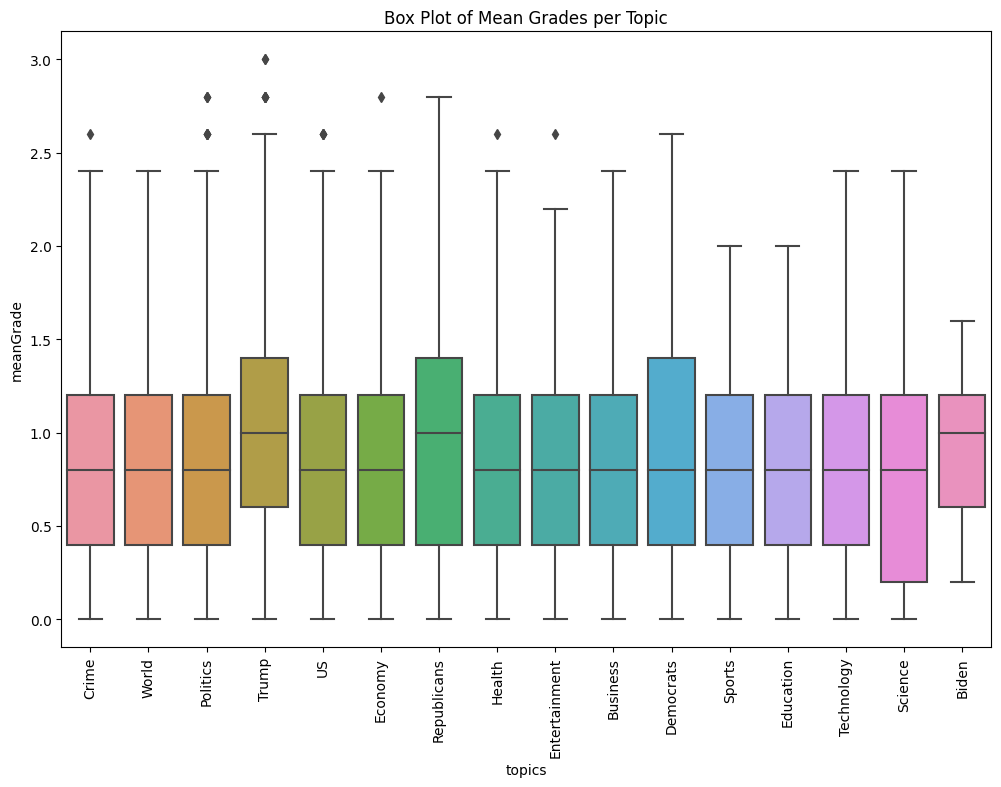

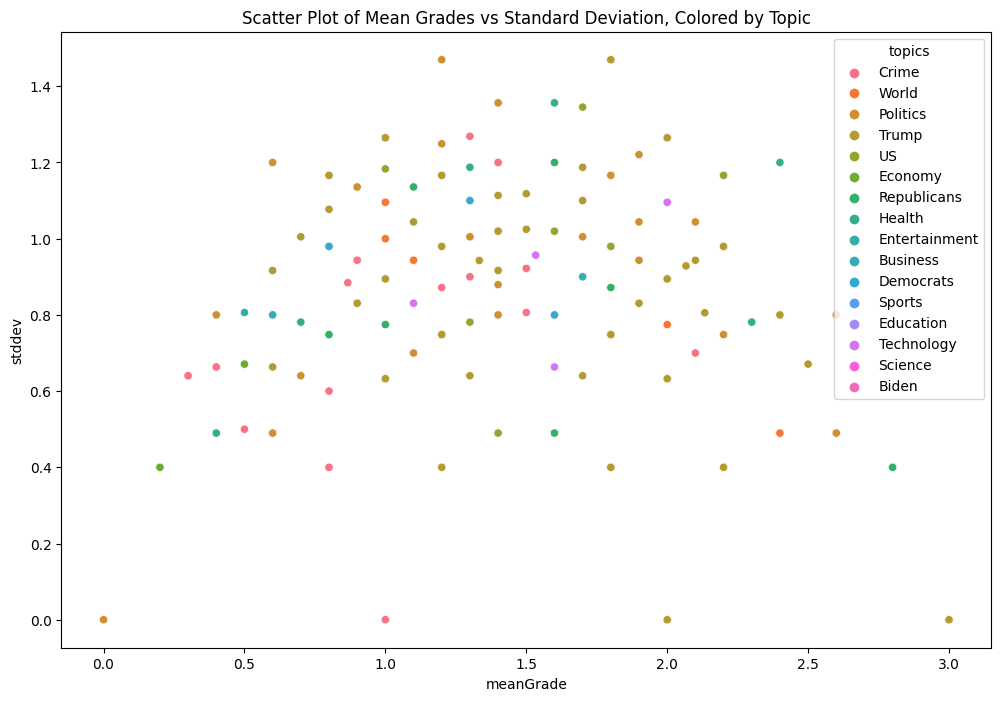

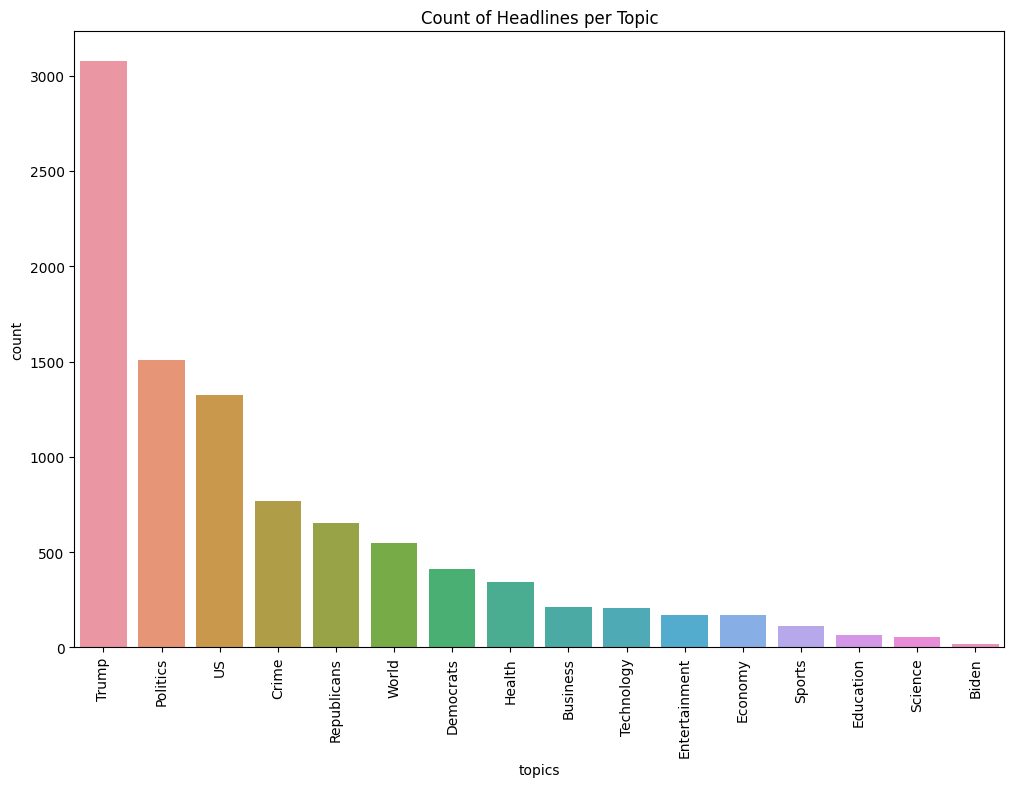

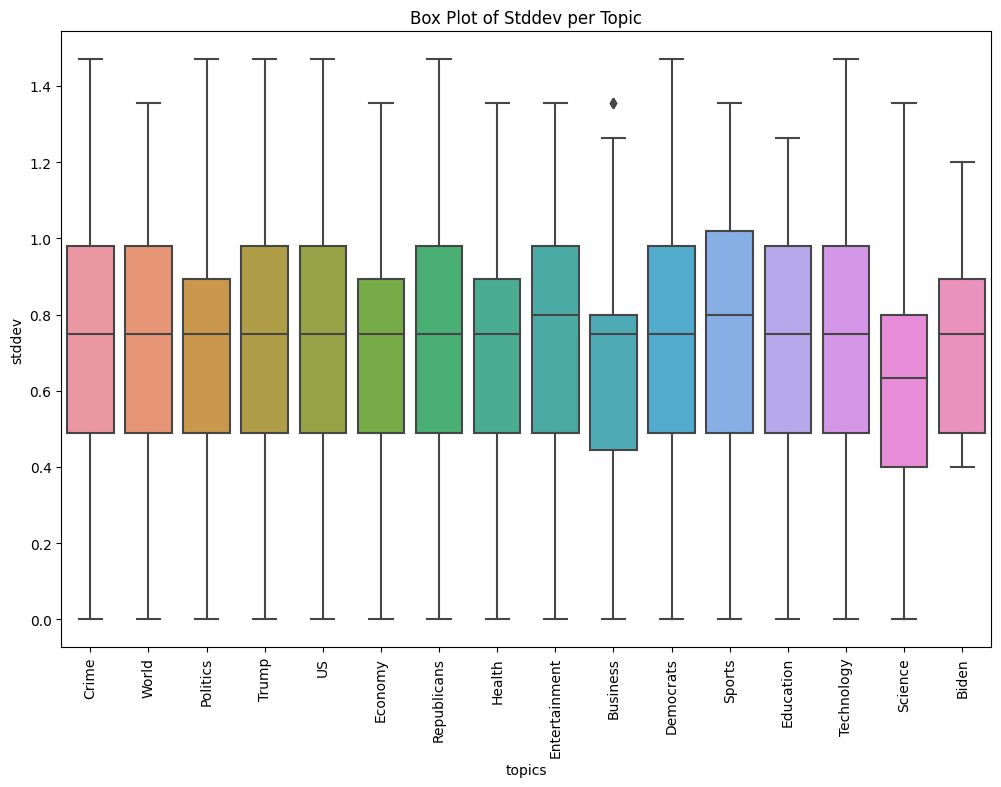

In [10]:
# Explode the dataframe on 'topics' so each topic is in a separate row
#df_exploded = df.explode('topics')
df_exploded = df.copy()
df_exploded['topics'] = df['topics'].apply(lambda ts: ts[0])

# Box plot of grades per topic
plt.figure(figsize=(12, 8))
sns.boxplot(x="topics", y="meanGrade", data=df_exploded)
plt.title('Box Plot of Mean Grades per Topic')
plt.xticks(rotation=90)
plt.show()

# Scatter plot of mean grades vs stddev, colored by topic
plt.figure(figsize=(12, 8))
sns.scatterplot(x="meanGrade", y="stddev", hue="topics", data=df_exploded)
plt.title('Scatter Plot of Mean Grades vs Standard Deviation, Colored by Topic')
plt.show()

# Two additional visualizations:
# 1. Count plot of topics
plt.figure(figsize=(12, 8))
sns.countplot(x="topics", data=df_exploded, order = df_exploded['topics'].value_counts().index)
plt.title('Count of Headlines per Topic')
plt.xticks(rotation=90)
plt.show()

# 2. Box plot of stddev per topic
plt.figure(figsize=(12, 8))
sns.boxplot(x="topics", y="stddev", data=df_exploded)
plt.title('Box Plot of Stddev per Topic')
plt.xticks(rotation=90)
plt.show()


9652


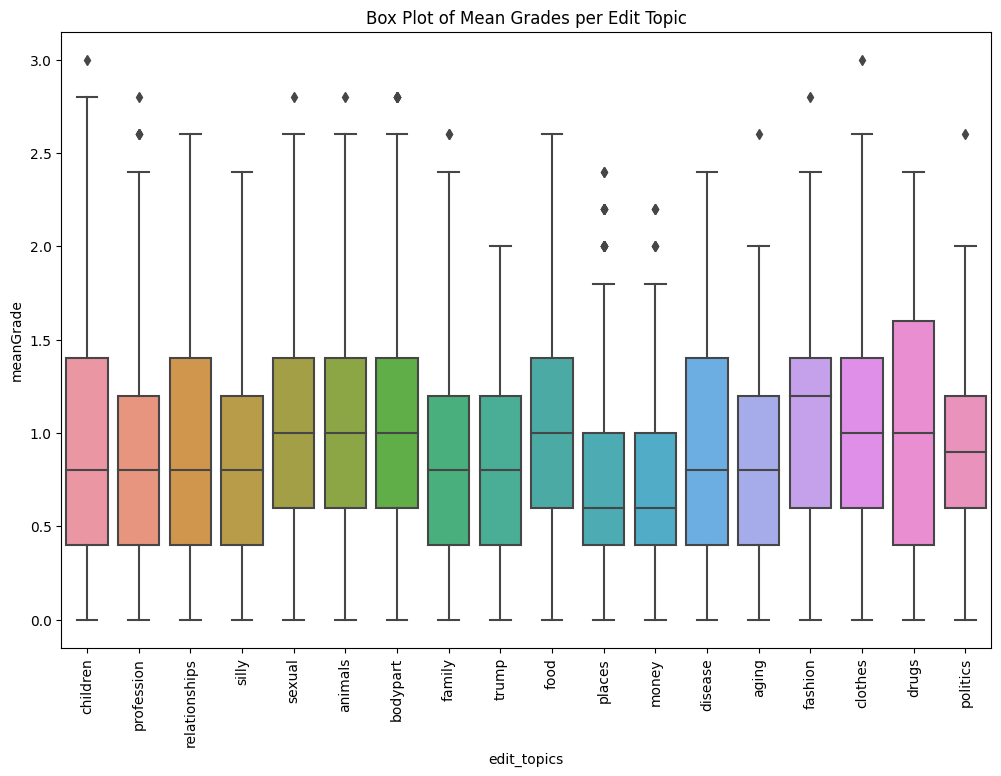

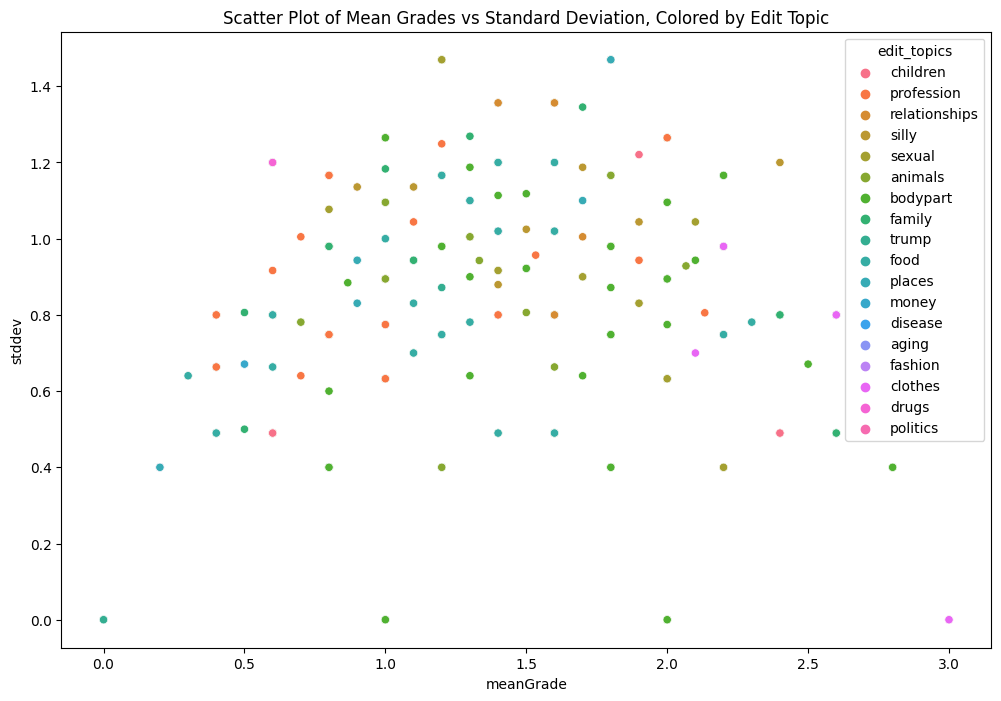

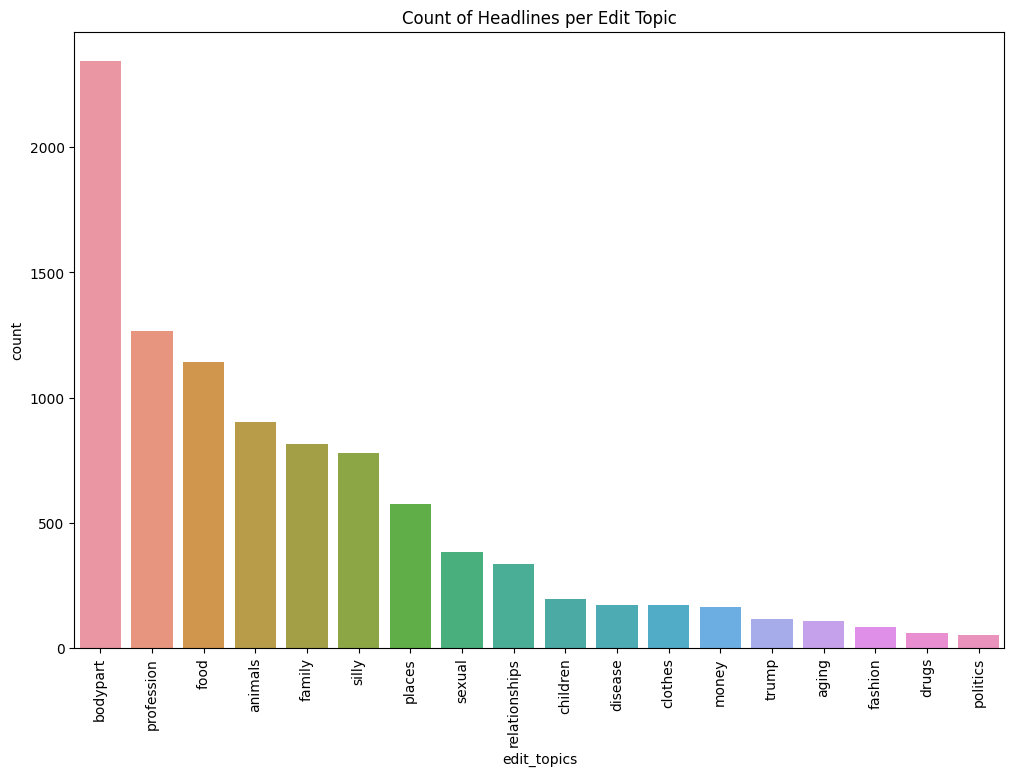

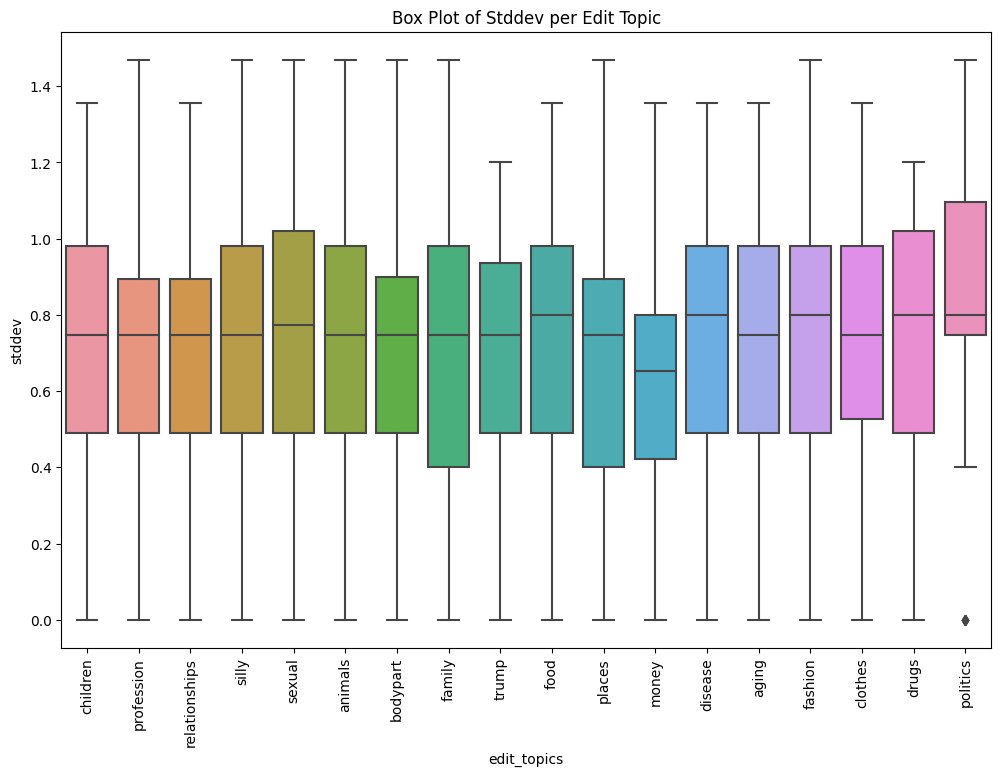

In [11]:
print(len(df.index))

# Explode the dataframe on 'topics' so each topic is in a separate row
#df_exploded = df.explode('topics')
df_edit_topics = df.copy()
df_edit_topics['edit_topics'] = df['edit_topics'].apply(lambda ts: ts[0])

# Box plot of grades per topic
plt.figure(figsize=(12, 8))
sns.boxplot(x="edit_topics", y="meanGrade", data=df_edit_topics)
plt.title('Box Plot of Mean Grades per Edit Topic')
plt.xticks(rotation=90)
plt.show()

# Scatter plot of mean grades vs stddev, colored by topic
plt.figure(figsize=(12, 8))
sns.scatterplot(x="meanGrade", y="stddev", hue="edit_topics", data=df_edit_topics)
plt.title('Scatter Plot of Mean Grades vs Standard Deviation, Colored by Edit Topic')
plt.show()

# Two additional visualizations:
# 1. Count plot of edit_topics
plt.figure(figsize=(12, 8))
sns.countplot(x="edit_topics", data=df_edit_topics, order = df_edit_topics['edit_topics'].value_counts().index)
plt.title('Count of Headlines per Edit Topic')
plt.xticks(rotation=90)
plt.show()

# 2. Box plot of stddev per topic
plt.figure(figsize=(12, 8))
sns.boxplot(x="edit_topics", y="stddev", data=df_edit_topics)
plt.title('Box Plot of Stddev per Edit Topic')
plt.xticks(rotation=90)
plt.show()


In [31]:
from collections import Counter

def process_grades(row):
    grades = list(map(int, list(row['grades_max_5'])))
    count = Counter(grades)
    most_common_grade, freq = count.most_common(1)[0]
    num_disagreements = len(grades) - freq

    #row['most_common_grade'] = most_common_grade if freq > 1 else None
    return num_disagreements, most_common_grade if freq > 1 else None

df['disagreements'], df['most_common_grade'] = zip(*df.apply(process_grades, axis=1))

# Create separate datasets based on the number of disagreements
df_all_agree = df[df['disagreements'] == 0]
df_one_disagree = df[df['disagreements'] == 1]
df_two_disagree = df[df['disagreements'] == 2]
df_three_disagree = df[df['disagreements'] == 3]
df_no_agreement = df[df['disagreements'] == 4]

#print type of most_common_grade
for i, row in df_all_agree.iterrows():
    print(type(row['most_common_grade']), type(row['meanGrade']))
    break

<class 'int'> <class 'float'>


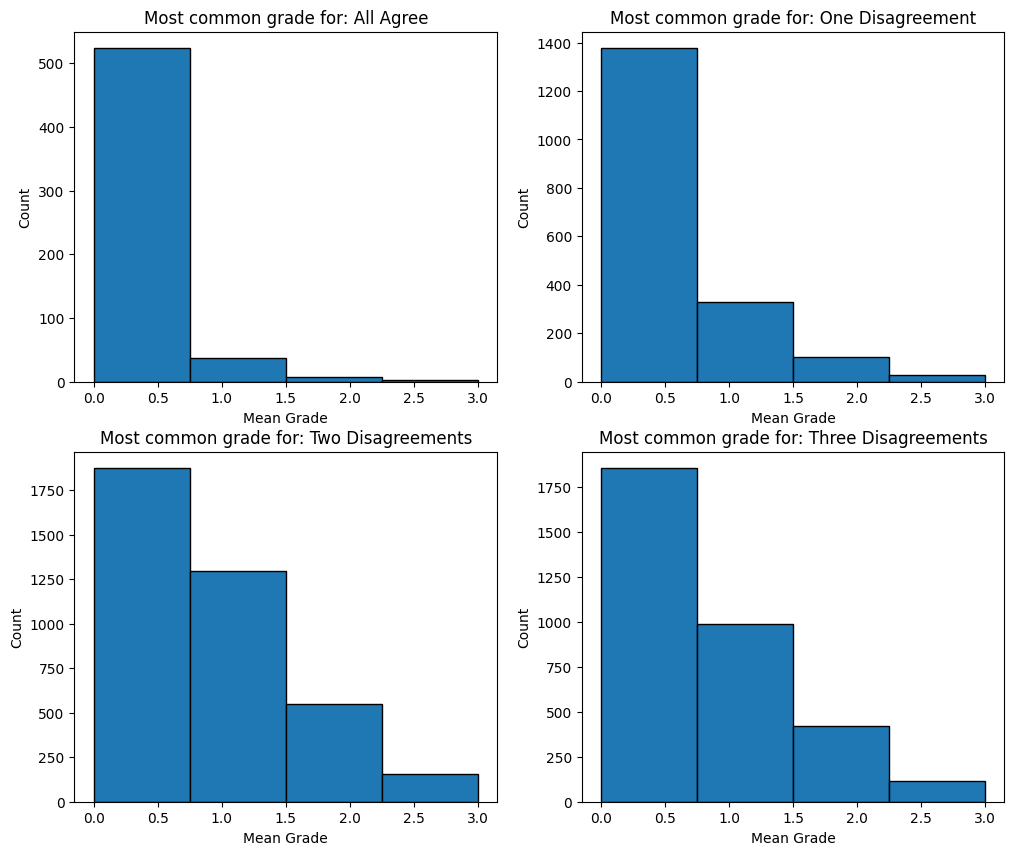

In [36]:
agreement_dfs = [df_all_agree, df_one_disagree, df_two_disagree, df_three_disagree]
agreement_names = ['All Agree', 'One Disagreement', 'Two Disagreements', 'Three Disagreements']

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
for i, df_agreement in enumerate(agreement_dfs):
    axs[i // 2, i % 2].hist(df_agreement['most_common_grade'], bins=4, edgecolor='black')
    axs[i // 2, i % 2].set_title(f"Most common grade for: {agreement_names[i]}")
    axs[i // 2, i % 2].set_xlabel('Mean Grade')
    axs[i // 2, i % 2].set_ylabel('Count')

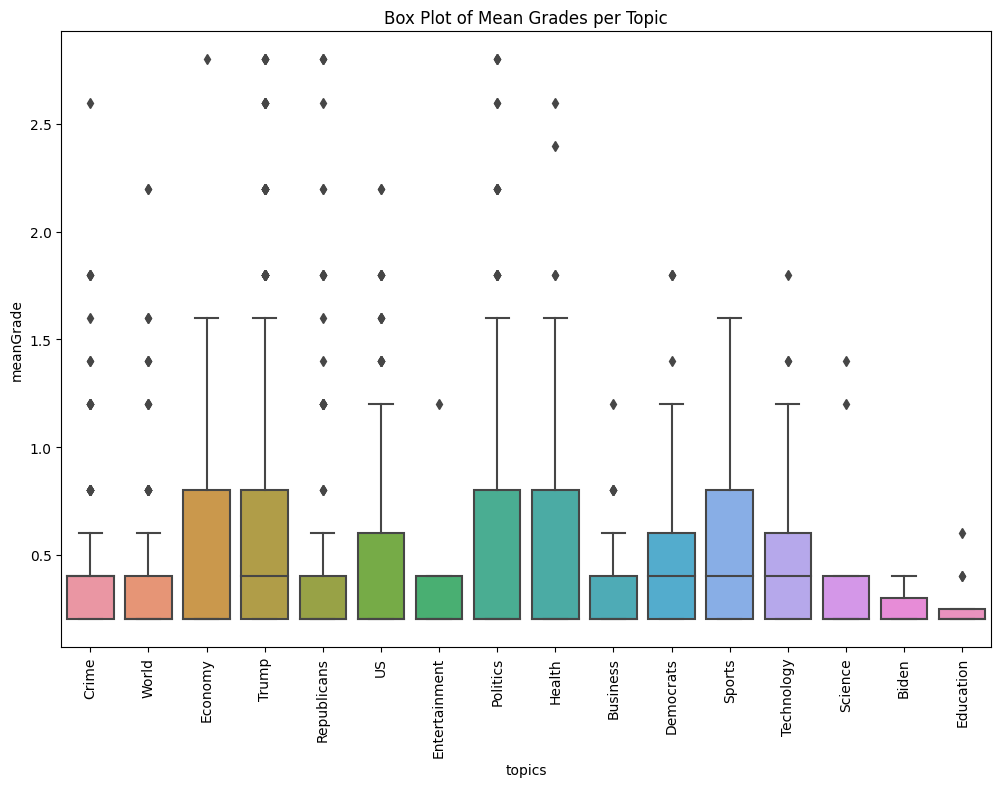

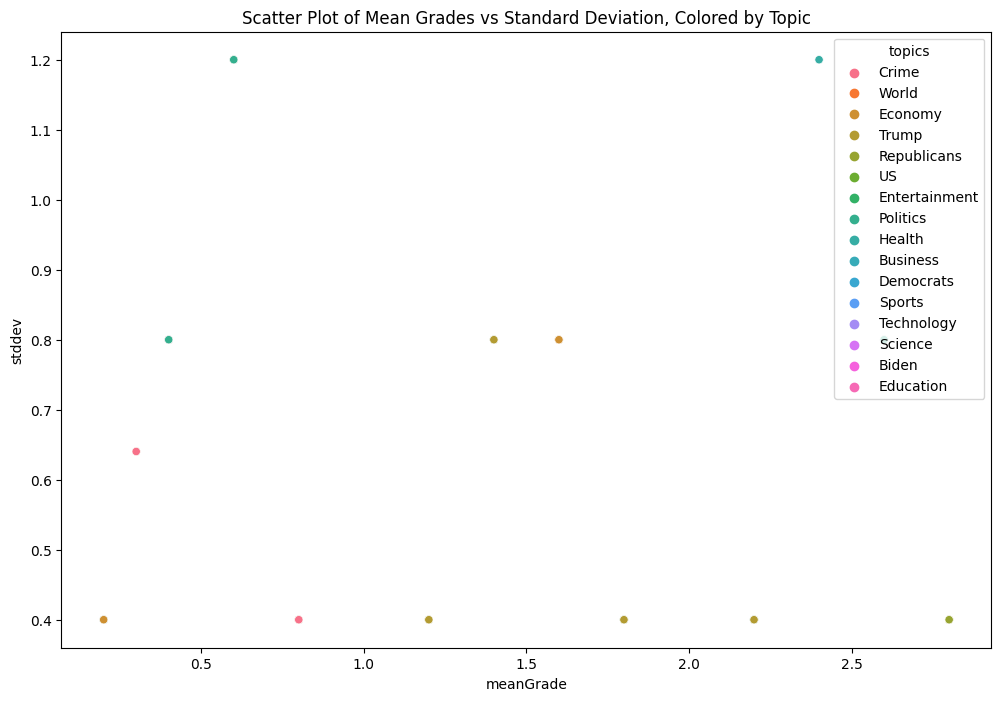

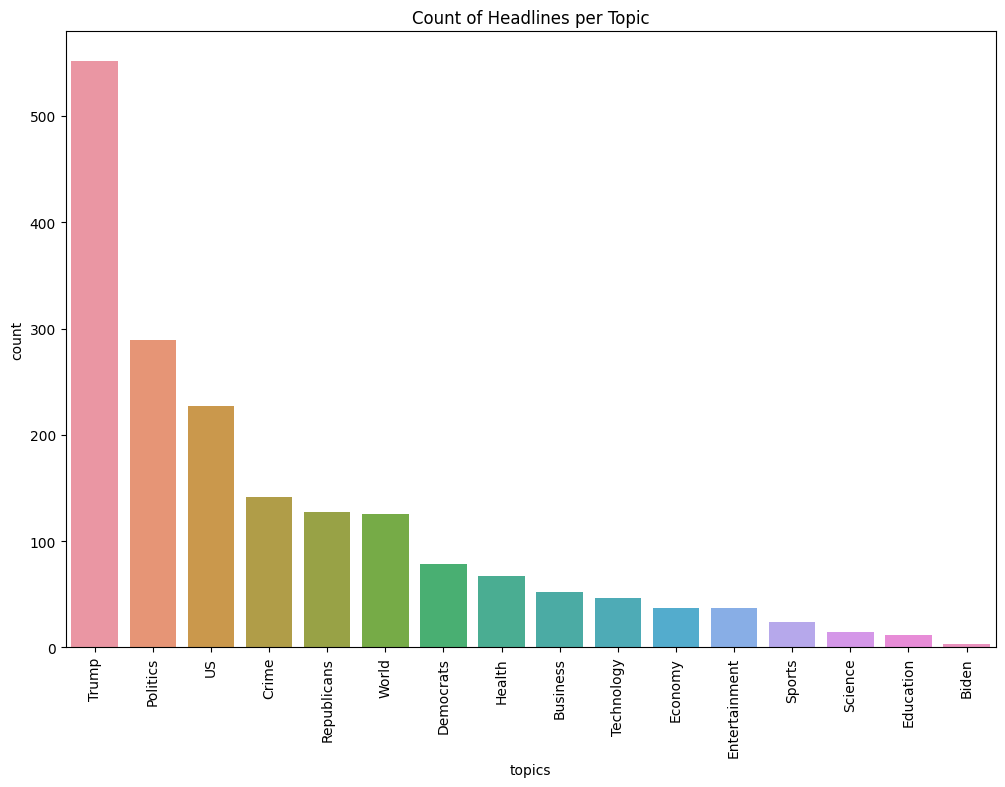

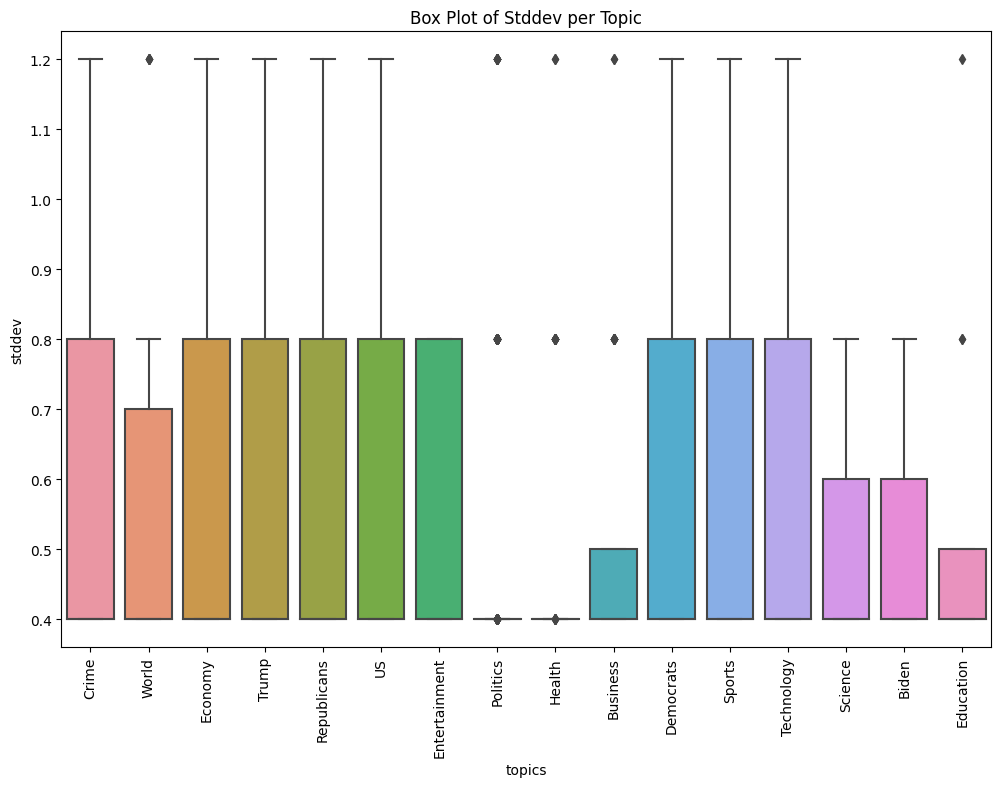

In [49]:
# Explode the dataframe on 'topics' so each topic is in a separate row
#df_exploded = df.explode('topics')
df_exploded = df_one_disagree.copy()
df_exploded['topics'] = df['topics'].apply(lambda ts: ts[0])

# for each topic, get the mean most common grade and stddev for most common grade, and set as new cols
df_exploded['most_common_grade'] = df_exploded['most_common_grade'].astype(float)
df_exploded['mean_most_common_grade'] = df_exploded.groupby('topics')['most_common_grade'].transform('mean')
df_exploded['stddev_most_common_grade'] = df_exploded.groupby('topics')['most_common_grade'].transform('std')

# Box plot of grades per topic
plt.figure(figsize=(12, 8))
sns.boxplot(x="topics", y="meanGrade", data=df_exploded)
plt.title('Box Plot of Mean Grades per Topic')
plt.xticks(rotation=90)
plt.show()

# Scatter plot of mean grades vs stddev, colored by topic
plt.figure(figsize=(12, 8))
sns.scatterplot(x="meanGrade", y="stddev", hue="topics", data=df_exploded)
plt.title('Scatter Plot of Mean Grades vs Standard Deviation, Colored by Topic')
plt.show()

# Two additional visualizations:
# 1. Count plot of topics
plt.figure(figsize=(12, 8))
sns.countplot(x="topics", data=df_exploded, order = df_exploded['topics'].value_counts().index)
plt.title('Count of Headlines per Topic')
plt.xticks(rotation=90)
plt.show()

# 2. Box plot of stddev per topic
plt.figure(figsize=(12, 8))
sns.boxplot(x="topics", y="stddev", data=df_exploded)
plt.title('Box Plot of Stddev per Topic')
plt.xticks(rotation=90)
plt.show()